# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

## Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

## Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение baseline
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Пути к директориям и файлам**

In [1]:
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

**Подключение необходимых пакетов**

In [2]:
import numpy as np
import pandas as pd

import pickle
import random

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 12

In [3]:
import warnings
warnings.simplefilter('ignore')

**Загрузка данных**

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df_train.shape

(7500, 17)

In [6]:
df_test.shape

(2500, 16)

## Обзор обучающего датасета

In [7]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

Типы приведены верно. Много пропусков.

**Обзор количественных признаков**

In [10]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


Есть выбросы.

**Обзор номинативных (категориальных) признаков**

In [11]:
for i, feauture in enumerate(df_train.select_dtypes(include='object').columns):
    print(str(i + 1) + ')', feauture, end='\n\n')
    print(df_train[feauture].value_counts(), end='\n\n')

1) Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

2) Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

3) Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

4) Term

Short Term    5556
Long Term     1944
Name: Term, dtype: int64



## Обработка выбросов

In [12]:
def project_boxplot(feature):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 5))
    fig.tight_layout(pad=4.0)
    ax[0].set_title('Train')
    ax[1].set_title('Test')
    sns.boxplot(y=feature, data=df_train, orient="h", palette="Set1", ax=ax[0])
    sns.boxplot(y=feature, data=df_test, orient="h", palette="Set2", ax=ax[1])
    plt.show()

#### Annual Income

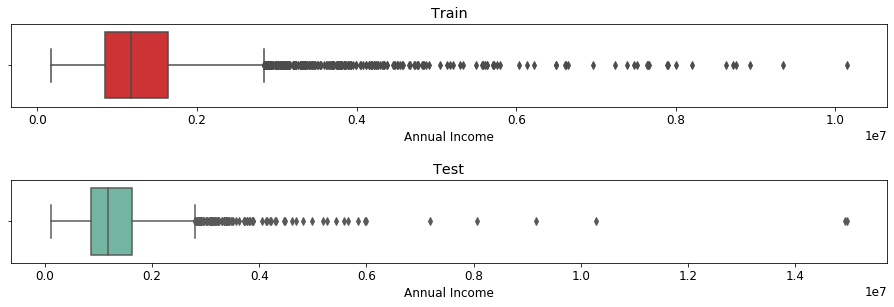

In [13]:
project_boxplot('Annual Income')

Оставляю как есть

#### Number of Open Accounts

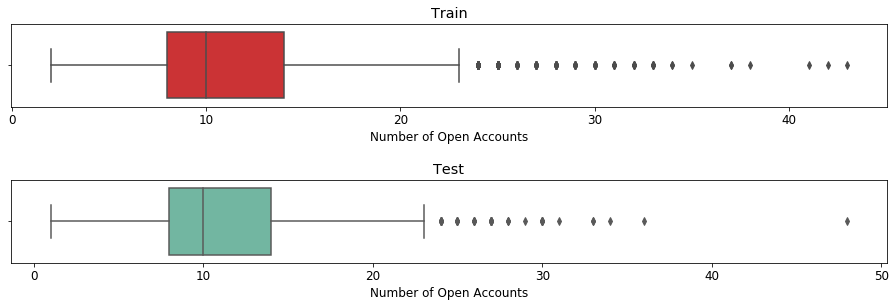

In [14]:
project_boxplot('Number of Open Accounts')

Тоже оставлю как есть

#### Years of Credit History

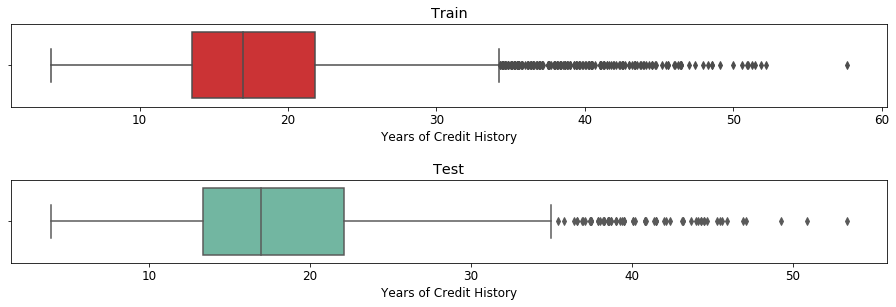

In [15]:
project_boxplot('Years of Credit History')

Посмотрим данные по людям с кредитной историей больше 50 лет

In [16]:
df_train[df_train['Years of Credit History'] > 50]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
247,Home Mortgage,1893426.0,NaN,0.0,7.0,52.2,711524.0,0.0,NaN,0.0,debt consolidation,Long Term,429880.0,500802.0,41024.0,654.0,1
476,Home Mortgage,1076768.0,NaN,0.0,14.0,57.7,432124.0,0.0,24.0,0.0,debt consolidation,Long Term,558360.0,186219.0,13818.0,667.0,1
3091,Rent,582141.0,NaN,0.0,7.0,50.9,487498.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,228190.0,7180.0,750.0,0
3628,Own Home,376314.0,NaN,0.0,8.0,51.3,139436.0,1.0,NaN,1.0,debt consolidation,Short Term,78980.0,99712.0,9972.0,720.0,0
4301,Home Mortgage,NaN,NaN,0.0,19.0,51.9,1602524.0,0.0,17.0,0.0,home improvements,Short Term,108152.0,384750.0,28280.0,NaN,0
4716,Rent,NaN,NaN,0.0,5.0,51.5,485672.0,0.0,14.0,0.0,debt consolidation,Long Term,614614.0,416518.0,16541.0,NaN,1
5673,Home Mortgage,949810.0,10+ years,0.0,15.0,50.6,1180388.0,0.0,71.0,0.0,debt consolidation,Long Term,439912.0,486267.0,15514.0,727.0,0
7251,Home Mortgage,NaN,10+ years,0.0,8.0,51.0,1769900.0,0.0,27.0,0.0,debt consolidation,Long Term,439252.0,1369577.0,22516.0,NaN,1


In [17]:
df_test[df_test['Years of Credit History'] > 50]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
993,Home Mortgage,NaN,10+ years,0.0,19.0,50.9,941226.0,0.0,48.0,0.0,debt consolidation,Short Term,219252.0,481232.0,25355.0,NaN
1268,Own Home,1742661.0,8 years,0.0,19.0,53.4,1417174.0,0.0,NaN,0.0,debt consolidation,Short Term,448404.0,652346.0,35870.0,701.0


Оставим как есть

#### Maximum Open Credit

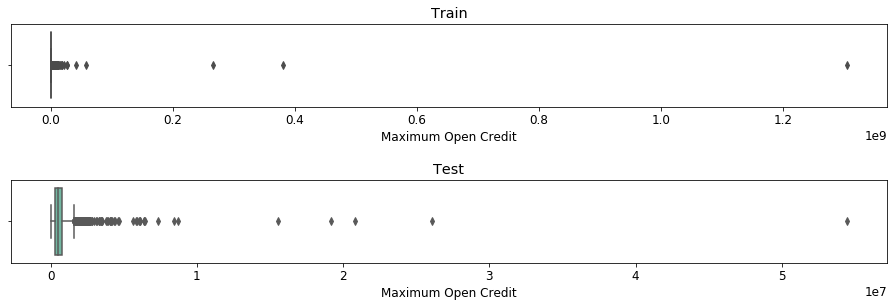

In [18]:
project_boxplot('Maximum Open Credit')

Здесь в тренировочной выборке похоже на ошибки в данных

In [19]:
df_train[df_train['Maximum Open Credit'] > 20000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,2.634333e+07,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0
5523,Home Mortgage,1520304.0,10+ years,0.0,21.0,35.5,2.137243e+07,0.0,0.0,0.0,other,Long Term,99999999.0,1975012.0,12555.0,728.0,0
7026,Home Mortgage,3312365.0,5 years,0.0,13.0,25.3,2.640700e+07,0.0,50.0,0.0,home improvements,Long Term,99999999.0,2440246.0,39196.0,745.0,0


Изменю значения в выбросах на 20.000.000

In [20]:
df_train.loc[df_train['Maximum Open Credit'] > 20000000, 'Maximum Open Credit'] = 20000000
df_test.loc[df_test['Maximum Open Credit'] > 20000000, 'Maximum Open Credit'] = 20000000

#### Current Loan Amount

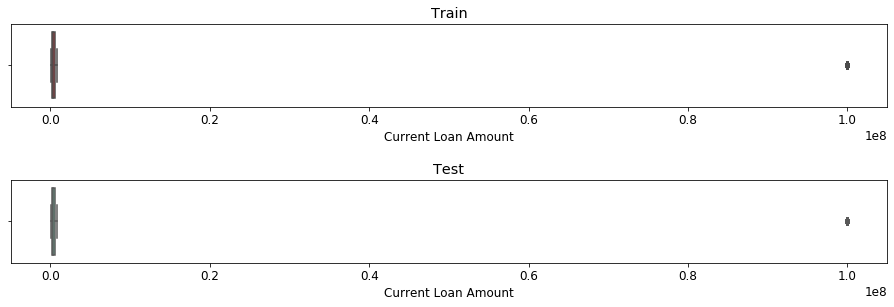

In [21]:
project_boxplot('Current Loan Amount')

Выбросы с дефолтными значениями равными 99999999

In [22]:
df_train[df_train['Current Loan Amount'] == 99999999]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
22,Rent,463790.0,NaN,0.0,6.0,28.3,288442.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,157700.0,5063.0,738.0,0
27,Rent,1004055.0,8 years,0.0,7.0,14.5,328394.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,195966.0,6041.0,734.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,Rent,1406836.0,1 year,0.0,12.0,22.6,2383260.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,461054.0,7386.0,747.0,0
7445,Home Mortgage,1564384.0,6 years,0.0,21.0,17.3,1545016.0,0.0,NaN,0.0,other,Long Term,99999999.0,1043442.0,32461.0,728.0,0
7464,Home Mortgage,1159152.0,6 years,0.0,14.0,22.0,389356.0,1.0,77.0,1.0,debt consolidation,Short Term,99999999.0,49438.0,18257.0,737.0,0
7475,Rent,848426.0,10+ years,0.0,8.0,20.1,526306.0,0.0,12.0,0.0,debt consolidation,Short Term,99999999.0,83638.0,16473.0,742.0,0


Значения не похожи на нулевые, заменим их на максимум до 99999999

In [23]:
max_loan_amount = df_train[df_train['Current Loan Amount'] < 99999999]['Current Loan Amount'].max()
max_loan_amount

789030.0

In [24]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = max_loan_amount
df_test.loc[df_test['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = max_loan_amount

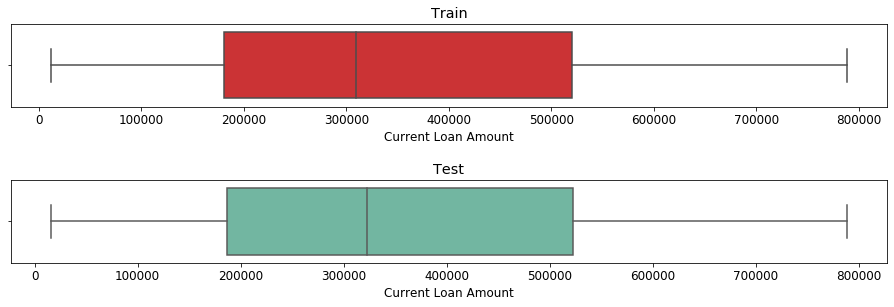

In [25]:
project_boxplot('Current Loan Amount')

#### Current Credit Balance

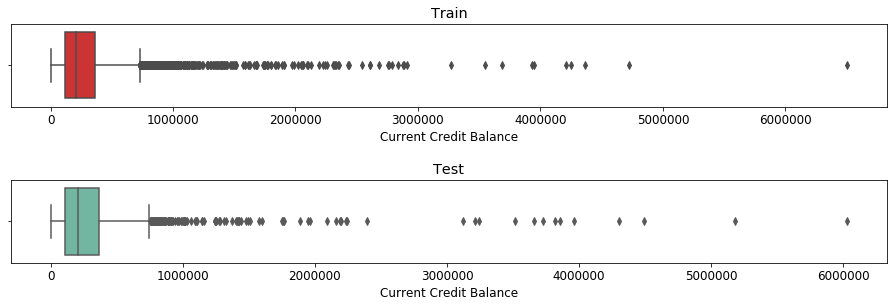

In [26]:
project_boxplot('Current Credit Balance')

In [27]:
df_train[df_train['Current Credit Balance'] >= 4000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1580,Home Mortgage,3783660.0,1 year,0.0,9.0,17.0,7204516.0,0.0,NaN,0.0,debt consolidation,Short Term,789030.0,4249673.0,42251.0,739.0,0
4602,Home Mortgage,3990038.0,10+ years,0.0,10.0,23.0,9541136.0,0.0,5.0,0.0,home improvements,Long Term,788788.0,4367245.0,29792.0,687.0,0
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0
4769,Home Mortgage,3739960.0,9 years,0.0,7.0,22.8,20000000.0,0.0,NaN,0.0,home improvements,Short Term,757834.0,6506797.0,38023.0,703.0,0
7278,Own Home,2418415.0,NaN,0.0,13.0,14.0,7453138.0,0.0,45.0,0.0,debt consolidation,Long Term,440088.0,4209659.0,29626.0,714.0,0


In [28]:
df_test[df_test['Current Credit Balance'] >= 4000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
228,Home Mortgage,3356255.0,10+ years,0.0,20.0,17.2,20000000.0,0.0,NaN,0.0,home improvements,Long Term,777238.0,5176018.0,42792.0,695.0
253,Home Mortgage,3863840.0,10+ years,0.0,20.0,28.6,6381078.0,0.0,5.0,0.0,debt consolidation,Long Term,789030.0,4304051.0,66973.0,727.0
285,Home Mortgage,5840220.0,10+ years,0.0,20.0,27.0,6425034.0,0.0,62.0,0.0,debt consolidation,Short Term,473374.0,4489054.0,84683.0,745.0
2152,Home Mortgage,NaN,10+ years,0.0,16.0,32.3,20000000.0,0.0,NaN,0.0,debt consolidation,Short Term,612502.0,6030087.0,75206.0,NaN


Оставим как есть

#### Monthly Debt

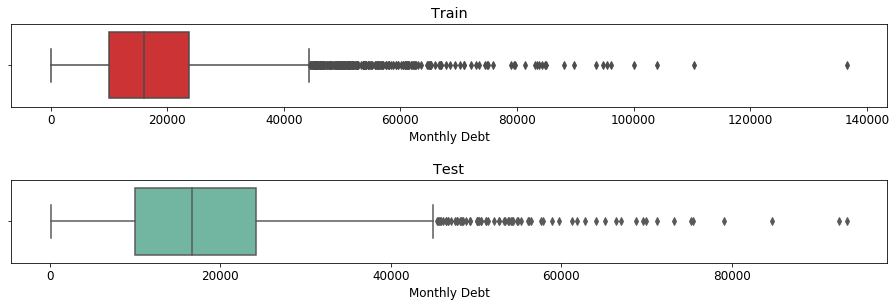

In [29]:
project_boxplot('Monthly Debt')

In [30]:
df_train[df_train['Monthly Debt'] >= 90000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
166,Home Mortgage,4580976.0,4 years,0.0,18.0,25.5,1553530.0,0.0,NaN,0.0,debt consolidation,Long Term,789030.0,633289.0,94674.0,727.0,0
280,Home Mortgage,NaN,10+ years,0.0,17.0,23.3,1051886.0,0.0,NaN,0.0,home improvements,Short Term,784322.0,518738.0,95508.0,NaN,1
1615,Own Home,6651900.0,10+ years,0.0,13.0,25.1,2155868.0,0.0,NaN,0.0,debt consolidation,Long Term,314380.0,1623569.0,110311.0,719.0,0
2535,Home Mortgage,4120226.0,10+ years,0.0,15.0,13.0,3931620.0,0.0,NaN,0.0,debt consolidation,Long Term,542146.0,2889577.0,104036.0,656.0,1
4745,Own Home,6029954.0,4 years,0.0,30.0,17.5,11603856.0,0.0,NaN,0.0,debt consolidation,Short Term,753588.0,4720132.0,136679.0,745.0,0
6253,Rent,NaN,4 years,0.0,12.0,16.5,828872.0,0.0,14.0,0.0,debt consolidation,Short Term,570262.0,589855.0,96177.0,NaN,0
6946,Own Home,6492395.0,1 year,0.0,19.0,26.0,1406526.0,0.0,NaN,0.0,other,Short Term,322190.0,1169773.0,100091.0,707.0,0
7478,Home Mortgage,3888160.0,6 years,0.0,30.0,16.3,1435456.0,0.0,21.0,0.0,debt consolidation,Short Term,787864.0,402914.0,93640.0,703.0,0


In [31]:
df_test[df_test['Monthly Debt'] >= 90000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
963,Rent,3238721.0,2 years,0.0,12.0,18.7,2673462.0,0.0,NaN,0.0,debt consolidation,Short Term,370590.0,2200390.0,92574.0,726.0
1426,Home Mortgage,3381506.0,5 years,0.0,13.0,13.0,6080470.0,0.0,NaN,0.0,debt consolidation,Short Term,66374.0,3854473.0,93555.0,741.0


In [32]:
df_train.loc[df_train['Monthly Debt'] > 100000, 'Monthly Debt'] = 100000

#### Credit Score

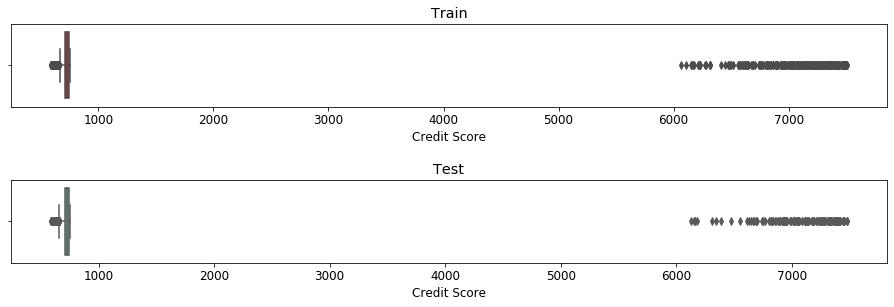

In [33]:
project_boxplot('Credit Score')

Похоже на ошибку вода данных. Похоже, на ошибку ровно в 10 раз.

Так как рейтинги варьируются от 600 до 750, у выбросов от 6000 до 7500.

Поэтому поделим все значения больше 1000 на 10.

In [34]:
df_train[df_train['Credit Score'] >= 1000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


In [35]:
df_train.loc[df_train['Credit Score'] > 1000, 'Credit Score'] /= 10
df_test.loc[df_test['Credit Score'] > 1000, 'Credit Score'] /= 10 

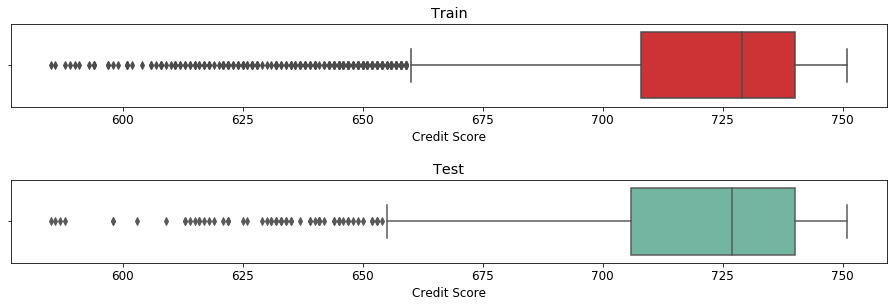

In [36]:
project_boxplot('Credit Score')

## Обработка пропусков и преобразование данных
Проблемы с пропусками в признаках:
* Annual Income
* Years in current job
* Months since last delinquent
* Bankruptcies
* Credit Score

In [37]:
print('Процент пропущенных значений по признакам')
(len(df_train) - df_train.count() ) / len(df_train) * 100

Процент пропущенных значений по признакам


Home Ownership                   0.000000
Annual Income                   20.760000
Years in current job             4.946667
Tax Liens                        0.000000
Number of Open Accounts          0.000000
Years of Credit History          0.000000
Maximum Open Credit              0.000000
Number of Credit Problems        0.000000
Months since last delinquent    54.413333
Bankruptcies                     0.186667
Purpose                          0.000000
Term                             0.000000
Current Loan Amount              0.000000
Current Credit Balance           0.000000
Monthly Debt                     0.000000
Credit Score                    20.760000
Credit Default                   0.000000
dtype: float64

Сразу избавимся от признака `Months since last delinquent`, так как в нем пропусков больше половины

In [38]:
df_train.drop('Months since last delinquent', axis=1, inplace=True)
df_test.drop('Months since last delinquent', axis=1, inplace=True)

#### Преобразование данных. Часть 1

Заметил, что в тестовой выборке нет данных с целью `renewable energy`. Заменю их на `other`.

In [39]:
df_train.loc[df_train['Purpose'] == 'renewable energy', 'Purpose'] = 'other'

In [40]:
df_train['Term'] = df_train['Term'].map({'Short Term': 0, 
                                         'Long Term':  1}).astype('uint8')
df_test['Term'] = df_test['Term'].map({'Short Term': 0, 
                                       'Long Term':  1}).astype('uint8')

df_train['Credit Default'] = df_train['Credit Default'].astype('uint8')

#### Обработка пропусков. Часть 1
Заполним пропущенные года на текущей работе модой. Это >10 лет.

In [41]:
years_mode = df_train['Years in current job'].mode()[0]

df_train['Years in current job'].fillna(value=years_mode, inplace=True)
df_test['Years in current job'].fillna(value=years_mode, inplace=True)

#### Dummies

In [42]:
df_train_dum = pd.get_dummies(df_train, drop_first=True)
df_test_dum = pd.get_dummies(df_test, drop_first=True)

#### Обработка пропусков. Часть 2
Доверю заполнение пропущенных значений готовому алгоритму `sklearn.impute.IterativeImputer`. В нем используется линейная регрессия.

In [43]:
imp_mean = IterativeImputer(random_state=21)
imp_mean.fit(df_train_dum.drop('Credit Default', axis=1))

df_train_0 = df_train_dum.drop('Credit Default', axis=1)
imp_df_train = pd.DataFrame(imp_mean.transform(df_train_0), columns=df_train_0.columns)
imp_df_test = pd.DataFrame(imp_mean.transform(df_test_dum), columns=df_test_dum.columns)

df_train_dum.fillna(imp_df_train, inplace=True)
df_test_dum.fillna(imp_df_test, inplace=True)

#### Преобразование данных. Часть 2
Приводим типы для сокращения используемой памяти.

Создаем наборы фиктивных переменных вместо категориальных.

In [44]:
for column in ['Tax Liens', 'Number of Open Accounts', 'Number of Credit Problems', 'Bankruptcies']:
    df_train_dum[column] = df_train_dum[column].astype(int)
    df_test_dum[column] = df_test_dum[column].astype(int)
    
y = df_train_dum['Credit Default']
X = df_train_dum.drop('Credit Default', axis=1)
X_t = df_test_dum.copy()

Теперь у нас 38 признаков. Попробуем сократить их число, максимально сохранив информацию в следующей главе.

In [45]:
print(X.shape)
print(X_t.shape)

(7500, 38)
(2500, 38)


Меняю порядок столбцов в тестовой выборке для красоты, но плюс этим шагом проверяю, что признаки совпадают

In [46]:
X_t = X_t[X.columns]

## Анализ данных

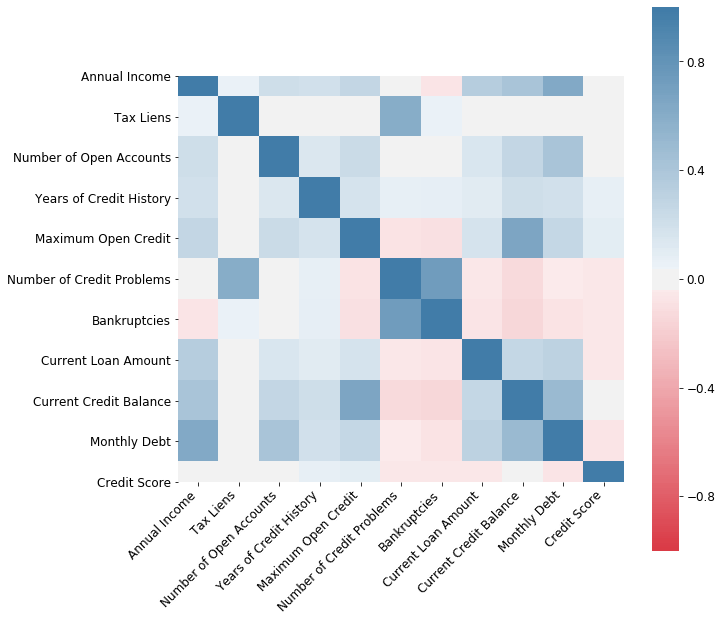

In [47]:
def heatmap(df):
    corr = df.corr()

    plt.figure(figsize=(10, 10))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(10, 240, n=200),
        square=True
    )

    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    plt.show()
    
heatmap(X.select_dtypes(exclude='uint8'));

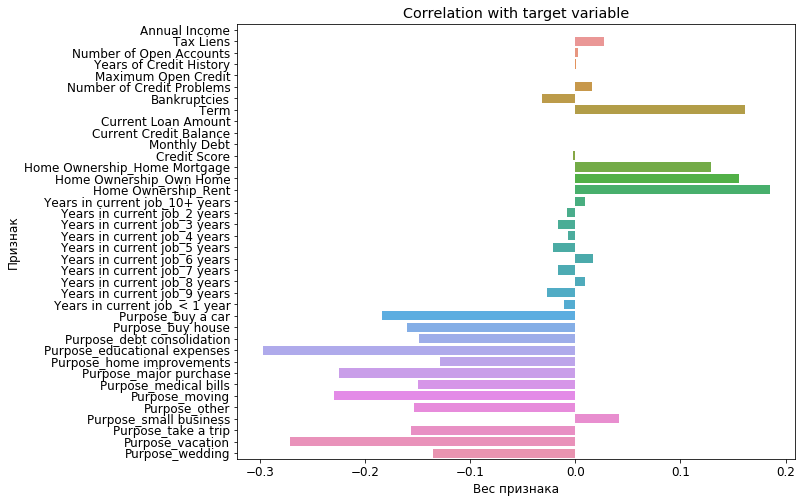

In [48]:
scaler = StandardScaler()
lr = LinearRegression()

scaler.fit_transform(X)
lr.fit(X, y)

plt.figure(figsize=(10, 8))

sns.barplot(x=lr.coef_.flatten(), y=X.columns)

plt.title('Correlation with target variable')
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

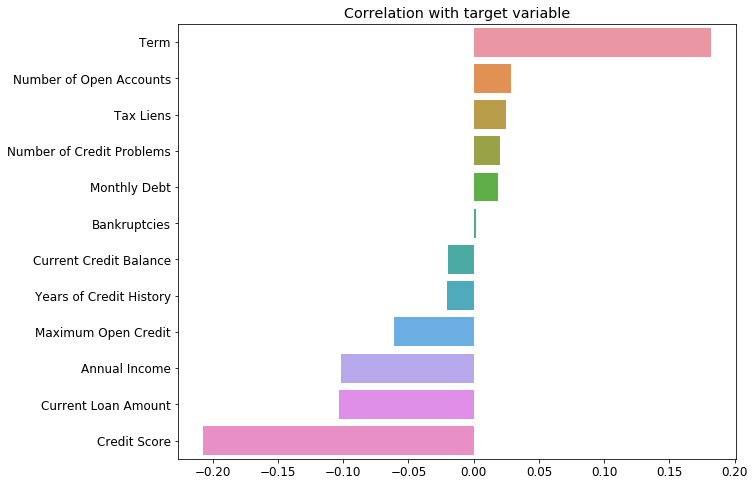

In [49]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Вручную не буду создавать новые признаки. Воспользуюсь методом главных компонент.

## Уменьшение числа признаков. Метод главных компонент

In [50]:
scaler = MinMaxScaler()
pca = PCA()

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data = X_scaled, columns=X.columns)

X_pca = pca.fit_transform(X_scaled)

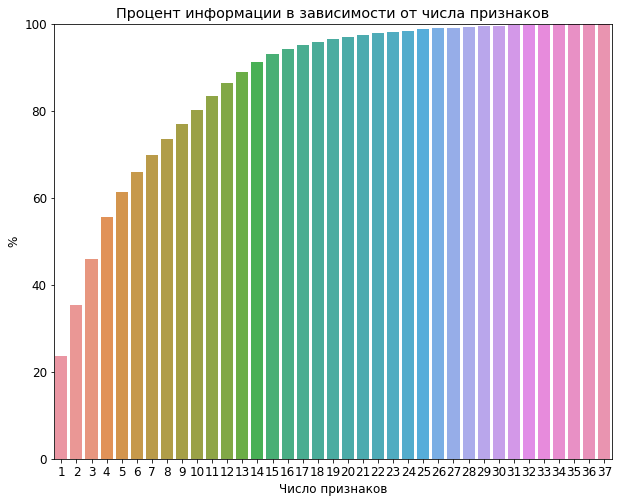

In [51]:
number_of_comp = range(1, len(X.columns))
info_percents = [100 * sum(pca.explained_variance_ratio_[: i]) for i in number_of_comp]

plt.figure(figsize=(10, 8))

sns.barplot(x=list(number_of_comp), y=info_percents)

plt.title('Процент информации в зависимости от числа признаков')
plt.xlabel('Число признаков')
plt.ylabel('%')
plt.ylim(top=100)
plt.show()

Оставлю 30 признаков

In [52]:
n_components = 30
pca30 = PCA(n_components)
X_pca = pca30.fit_transform(X_scaled)
X_pca = pd.DataFrame(data = X_pca, columns=['f' + str(i) for i in range(1, n_components + 1)])

Применяем метод главных компонент и к тестовой выборке

In [53]:
X_test_scaled = scaler.transform(X_t)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns=X_t.columns)

X_test_pca = pca30.transform(X_test_scaled)
X_test_pca = pd.DataFrame(data = X_test_pca, columns=['f' + str(i) for i in range(1, n_components + 1)])

## Балансировка классов

In [54]:
def project_pie(y, title):
    values = y.value_counts() * 10**4 // len(y) / 100
    labels = ['Закрытый кредит', 'Просроченный кредит']

    plt.pie(values, labels=labels, autopct='%.2f%%', startangle=90, pctdistance=1.3, labeldistance=1.6, explode=(0.05, 0))
    plt.title(title)
    plt.legend(frameon=False, bbox_to_anchor=(1.5, 0.3))
    plt.show()

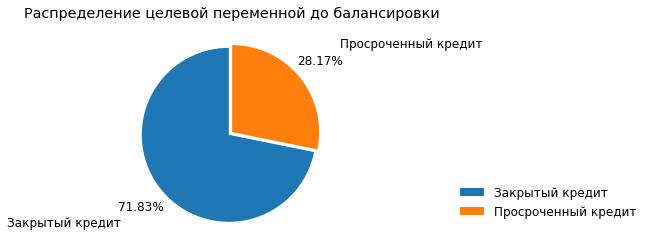

In [55]:
project_pie(y, 'Распределение целевой переменной до балансировки')

In [56]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    
    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [57]:
df_for_balancing = pd.concat([X_pca, y], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')

y_balanced = df_balanced['Credit Default']
X_balanced = df_balanced.drop('Credit Default', axis=1)

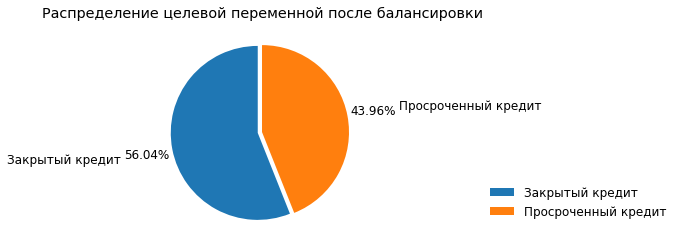

In [58]:
project_pie(y_balanced, 'Распределение целевой переменной после балансировки')

## Подбор моделей. Выбор наилучшей модели, настройка гиперпараметров

* Random Forest Classifier
* Logistic Regression
* K-nearest Neighbors
* XGBoost
* LightBoost
* CatBoost

In [59]:
results = pd.DataFrame(columns=[
    'Model', 
    'F1', 
    'Accuracy', 
    'Precision', 
    'Recall', 
    'Best F1 Train', 
    'Best Params', 
    'Constant Params'
])

Функция поиска моделей результаты будет добавлять в список `results`

In [60]:
def myGridSearch(model_name, model, X, y, const_params, hyper_params):
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.25, 
        shuffle=True,
        random_state=21
    )
    
    result = {'Model': model_name}
    
    grid = GridSearchCV(
        estimator=model(**const_params),
        param_grid=hyper_params,
        scoring='f1',
        n_jobs=-1,
        cv=KFold(
            n_splits=5, 
            shuffle=True, 
            random_state=21
        )
    )
    
    grid.fit(X_train, y_train)
    
    result['Best Params'] = grid.best_params_
    result['Constant Params'] = const_params
    result['Best F1 Train'] = grid.best_score_
    
    best_model = model(**grid.best_params_, **const_params)
    best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    result['F1'] = f1_score(y_test, y_pred)
    result['Accuracy'] = accuracy_score(y_test, y_pred)
    result['Precision'] = precision_score(y_test, y_pred)
    result['Recall'] = recall_score(y_test, y_pred)
    
    return result

#### Random Forest Classifier

In [61]:
%%time
const_params = {
    'class_weight': 'balanced',
    'random_state': 21,
    'n_jobs': -1
}

hyper_params = {
    'n_estimators': np.arange(100, 301, 100),
    'max_depth': np.arange(5, 10, 2),
    'min_samples_split': np.arange(8, 13, 2)
}

result = myGridSearch(
    'Random Forest',
    RandomForestClassifier,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 1min 18s


#### Logistic Regression

In [62]:
%%time
const_params = {
    'class_weight': 'balanced',
    'random_state': 21,
    'n_jobs': -1
}

hyper_params = {
    'tol': [1e-5, 1e-3, 1e-1, 1],
    'max_iter': [300, 500, 700]
}

result = myGridSearch(
    'Log Regression',
    LogisticRegression,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 2.51 s


#### K-nearest Neighbors

In [63]:
%%time
const_params = {
    'n_jobs': -1
}

hyper_params = {
    'n_neighbors': np.arange(9, 32, 2),
    'weights': ['uniform', 'distance']
}

result = myGridSearch(
    'k-NN',
    KNeighborsClassifier,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 2.8 s


#### XGBoost

In [79]:
%%time
const_params = {
    'random_state': 21,
    'n_jobs': -1
}

hyper_params = {
    'n_estimators': np.arange(8, 15, 2),
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'max_depth': [3, 5, 7, 10],
    'base_score': [.3, .5, .7]
}

result = myGridSearch(
    'XGBoost',
    XGBClassifier,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 16.9 s


#### LightBoost

In [73]:
%%time
const_params = {
    'class_weight': 'balanced',
    'random_state': 21,
    'n_jobs': -1
}

hyper_params = {
    'n_estimators': [30, 50, 100, 200],
    'learning_rate': [1e-3, 1e-2, 1e-1, 1],
    'max_depth': [5, 7, 9],
    'num_leaves': [200, 300, 400]
}

result = myGridSearch(
    'LightBoost',
    LGBMClassifier,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 1min 50s


#### CatBoost

In [74]:
%%time
const_params = {
    'silent': True,
    'l2_leaf_reg': 10,
    'random_state': 21
}

hyper_params = {
    'iterations': np.arange(200, 501, 100),
    'learning_rate': [1e-5, 1e-3, 1e-1, 1],
    'depth': np.arange(3, 8, 2)
}

result = myGridSearch(
    'CatBoost',
    CatBoostClassifier,
    X_balanced,
    y_balanced,
    const_params,
    hyper_params
)

results = results.append(result, ignore_index=True)

Wall time: 5min 30s


In [80]:
results

,Model,F1,Accuracy,Precision,Recall,Best F1 Train,Best Params,Constant Params
0,Random Forest,0.670396,0.681364,0.620223,0.729401,0.678481,"{'max_depth': 9, 'min_samples_split': 8, 'n_es...","{'class_weight': 'balanced', 'random_state': 2..."
1,Log Regression,0.587006,0.621880,0.570168,0.604869,0.586483,"{'max_iter': 300, 'tol': 0.001}","{'class_weight': 'balanced', 'random_state': 2..."
2,k-NN,0.766096,0.761231,0.678211,0.880150,0.737462,"{'n_neighbors': 27, 'weights': 'distance'}",{'n_jobs': -1}
3,XGBoost,0.779221,0.787854,0.724638,0.842697,0.751360,"{'base_score': 0.3, 'learning_rate': 1, 'max_d...","{'random_state': 21, 'n_jobs': -1}"
4,LightBoost,0.753611,0.758735,0.689736,0.830524,0.719443,"{'learning_rate': 1, 'max_depth': 5, 'n_estima...","{'class_weight': 'balanced', 'random_state': 2..."
5,CatBoost,0.763134,0.778702,0.727504,0.802434,0.730815,"{'depth': 7, 'iterations': 500, 'learning_rate...","{'silent': True, 'l2_leaf_reg': 10, 'random_st..."


## Интерпретация результатов

Я выбрал модель XGBoost на основе свобной таблице выше.

Эта модель показала высокие значения f1 метрики, а главное, f1 тестовая и тренировочная близки, а значит мало переобучения.

У моделей Random Forest и Log Regression метрики f1 почти совпадают для тестовой и тренировочной выборки. Что очень хорошо в плане отсуттвия переобучения, но значения сильно ниже XGBoost. Поэтому я выбрал XGBoost.

In [68]:
model_name = 'XGBoost'
model = XGBClassifier

In [69]:
best_params = list(results.loc[results['Model'] == model_name, 'Best Params'])[0]
const_params = list(results.loc[results['Model'] == model_name, 'Constant Params'])[0]

In [71]:
best_model = model(**best_params, **const_params)
best_model.fit(X_balanced, y_balanced)
y_pred = pd.DataFrame(best_model.predict(X_test_pca), columns=['Credit Default'])

In [72]:
y_pred.to_csv('Batorov_predictions.csv', index=None, header=False)